# Statistical Analysis on factors influencing Life Expenteancy

## https://www.kaggle.com/kumarajarshi/life-expectancy-who

In [66]:
import pandas as pd
import math
import numpy as np
from numpy import percentile
from numpy.random import seed
from sqlalchemy import create_engine
import scipy.stats as stats
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import boxcox
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

##  We want to understand the relationship between the expenditures of the governments and the students' overall success in the math and reading.

In [207]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df0 = pd.read_sql_query('select * from lifeexpectancy', con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

## Explore the data

In [208]:
nRow, nCol = df0.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 2938 rows and 22 columns


In [209]:
# Help functions to gather basic descriptions
def describe(df):
    return pd.concat([df.describe().T,
                      df.mad().rename('mean abs dev'),
                      df.skew().rename('skew'),
                      df.kurt().rename('kurt'),
                      df.nunique().rename('unique')
                     ], axis=1).T

In [210]:
# Non-numerical describe
df_stat = df0.describe(include = ['O']) 
df_stat.loc['dtype'] = df0.dtypes
df_stat.loc['size'] = len(df0)
df_stat.loc['% null'] = df0.isnull().mean().round(2)
df_stat

,Country,Status
count,2938,2938
unique,193,2
top,South Africa,Developing
freq,16,2426
dtype,object,object
size,2938,2938
% null,0,0


In [211]:
# Numerical describe
df_stat = df0.describe(include = [np.number]) 
df_stat.loc['dtype'] = df0.dtypes
df_stat.loc['size'] = len(df0)
df_stat.loc['% null'] = df0.isnull().mean().round(2)
df_stat

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938,2928,2928,2938,2744,2938,2385,2938,2904,2938,2919,2712,2919,2938,2490,2286,2904,2904,2771,2775
mean,2007.52,69.2249,164.796,30.3039,4.60286,738.251,80.9405,2419.59,38.3212,42.0357,82.5502,5.93819,82.3241,1.7421,7483.16,1.27534e+07,4.8397,4.87032,0.627551,11.9928
std,4.61384,9.52387,124.292,117.927,4.05241,1987.91,25.07,11467.3,20.044,160.446,23.428,2.49832,23.7169,5.07778,14270.2,6.10121e+07,4.42019,4.50888,0.210904,3.35892
min,2000,36.3,1,0,0.01,0,1,0,1,0,3,0.37,2,0.1,1.68135,34,0.1,0.1,0,0
25%,2004,63.1,74,0,0.8775,4.68534,77,0,19.3,0,78,4.26,78,0.1,463.936,195793,1.6,1.5,0.493,10.1
50%,2008,72.1,144,3,3.755,64.9129,92,17,43.5,4,93,5.755,93,0.1,1766.95,1.38654e+06,3.3,3.3,0.677,12.3
75%,2012,75.7,228,22,7.7025,441.534,97,360.25,56.2,28,97,7.4925,97,0.8,5910.81,7.42036e+06,7.2,7.2,0.779,14.3
max,2015,89,723,1800,17.87,19479.9,99,212183,87.3,2500,99,17.6,99,50.6,119173,1.29386e+09,27.7,28.6,0.948,20.7
dtype,int64,float64,float64,int64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
size,2938,2938,2938,2938,2938,2938,2938,2938,2938,2938,2938,2938,2938,2938,2938,2938,2938,2938,2938,2938


In [212]:
# # Drop unnecessary columns
# df0 = df0.drop(['Year', 'Status', 'Country'], axis=1)

In [213]:
# Clean the columns headings
df0.columns = ['Country', 'Status', 'Year', 'Life_Expectancy', 'Adult_Mortality', 'Infant_Deaths' \
               , 'Alcohol', 'Percentage_Exp', 'HepatitisB','Measles','BMI',  'Under_Five_Deaths',  'Polio',  'Tot_Exp'\
               , 'Diphtheria',  'HIV/AIDS', 'GDP',  'Population',  'Thinness_1to19_Years', 'Thinness_5to9_Years' \
               , 'Income_Comp_of_Resources', 'Schooling']

In [214]:
# Numerical describe
df_stat = df0.describe(include = [np.number]) 
df_stat.loc['dtype'] = df0.dtypes
df_stat.loc['size'] = len(df0)
df_stat.loc['% null'] = df0.isnull().mean().round(2)
df_stat

,Status,Life_Expectancy,Adult_Mortality,Infant_Deaths,Alcohol,Percentage_Exp,HepatitisB,Measles,BMI,Under_Five_Deaths,Polio,Tot_Exp,Diphtheria,HIV/AIDS,GDP,Population,Thinness_1to19_Years,Thinness_5to9_Years,Income_Comp_of_Resources,Schooling
count,2938,2928,2928,2938,2744,2938,2385,2938,2904,2938,2919,2712,2919,2938,2490,2286,2904,2904,2771,2775
mean,2007.52,69.2249,164.796,30.3039,4.60286,738.251,80.9405,2419.59,38.3212,42.0357,82.5502,5.93819,82.3241,1.7421,7483.16,1.27534e+07,4.8397,4.87032,0.627551,11.9928
std,4.61384,9.52387,124.292,117.927,4.05241,1987.91,25.07,11467.3,20.044,160.446,23.428,2.49832,23.7169,5.07778,14270.2,6.10121e+07,4.42019,4.50888,0.210904,3.35892
min,2000,36.3,1,0,0.01,0,1,0,1,0,3,0.37,2,0.1,1.68135,34,0.1,0.1,0,0
25%,2004,63.1,74,0,0.8775,4.68534,77,0,19.3,0,78,4.26,78,0.1,463.936,195793,1.6,1.5,0.493,10.1
50%,2008,72.1,144,3,3.755,64.9129,92,17,43.5,4,93,5.755,93,0.1,1766.95,1.38654e+06,3.3,3.3,0.677,12.3
75%,2012,75.7,228,22,7.7025,441.534,97,360.25,56.2,28,97,7.4925,97,0.8,5910.81,7.42036e+06,7.2,7.2,0.779,14.3
max,2015,89,723,1800,17.87,19479.9,99,212183,87.3,2500,99,17.6,99,50.6,119173,1.29386e+09,27.7,28.6,0.948,20.7
dtype,int64,float64,float64,int64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
size,2938,2938,2938,2938,2938,2938,2938,2938,2938,2938,2938,2938,2938,2938,2938,2938,2938,2938,2938,2938


## Explore and fix any outliers

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20]),
 <a list of 20 Text major ticklabel objects>)

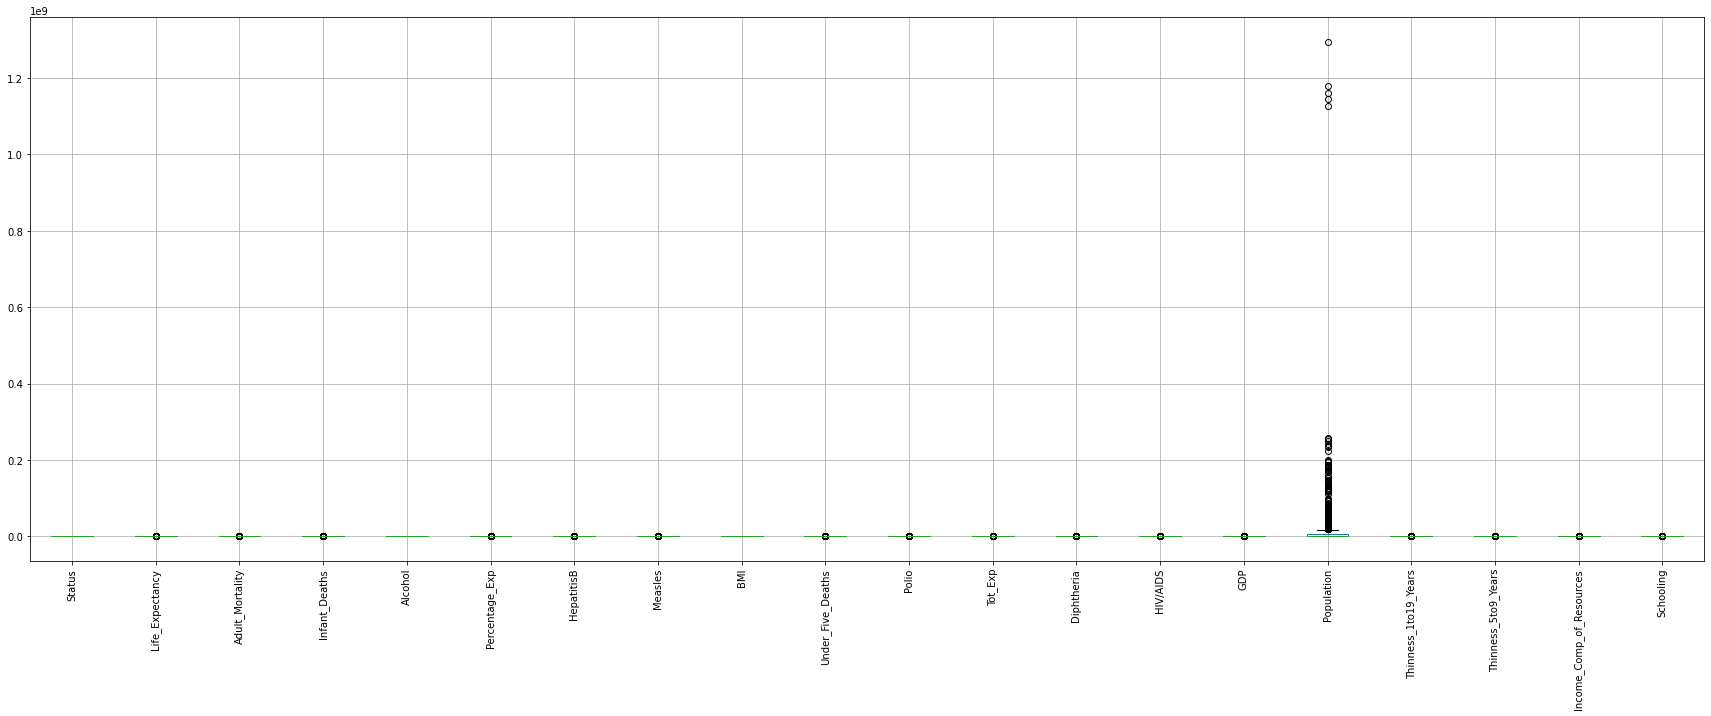

In [215]:
plt.figure(figsize = (30,10))
df0.boxplot()
plt.xticks(rotation=90)


In [216]:
# Identify percentage of null values in each column.
df0.isnull().sum()*100/df0.isnull().count()

Country                      0.000000
Status                       0.000000
Year                         0.000000
Life_Expectancy              0.340368
Adult_Mortality              0.340368
Infant_Deaths                0.000000
Alcohol                      6.603131
Percentage_Exp               0.000000
HepatitisB                  18.822328
Measles                      0.000000
BMI                          1.157250
Under_Five_Deaths            0.000000
Polio                        0.646698
Tot_Exp                      7.692308
Diphtheria                   0.646698
HIV/AIDS                     0.000000
GDP                         15.248468
Population                  22.191967
Thinness_1to19_Years         1.157250
Thinness_5to9_Years          1.157250
Income_Comp_of_Resources     5.684139
Schooling                    5.547992
dtype: float64

In [217]:
country_list = df0.Country.unique()
fill_list = ['Life_Expectancy','Adult_Mortality','Alcohol','HepatitisB','BMI','Polio'\
             ,'Tot_Exp','Diphtheria','GDP','Population','Thinness_1to19_Years','Thinness_5to9_Years'\

             ,'Income_Comp_Of_Resources','Schooling']


## Remove null values using interpolate()

In [218]:
df0.interpolate(method='linear',inplace=True)

In [219]:
# Remove null values using interpolate()


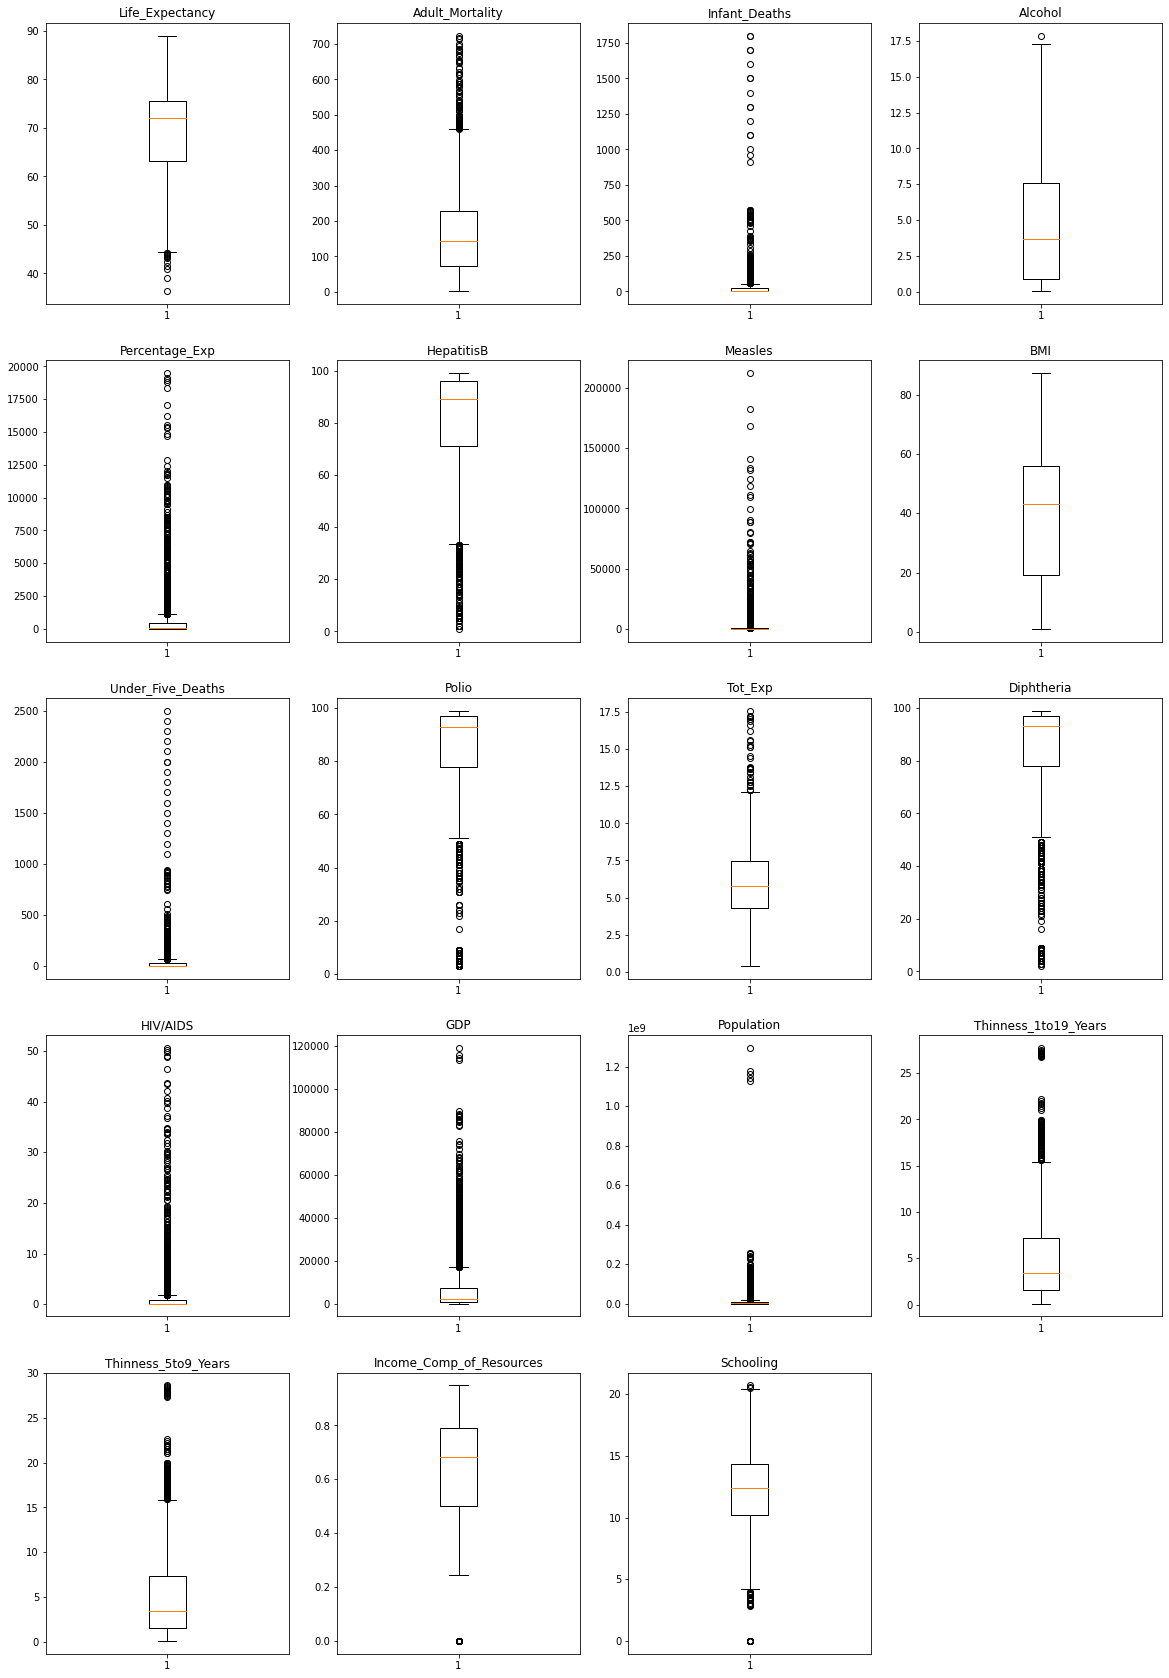

In [220]:
# Deleting outliers for each variable
col_dict = {'Life_Expectancy':1,'Adult_Mortality':2,'Infant_Deaths':3,'Alcohol':4\
            ,'Percentage_Exp':5,'HepatitisB':6,'Measles':7,'BMI':8,'Under_Five_Deaths':9,'Polio':10,'Tot_Exp':11\
            ,'Diphtheria':12,'HIV/AIDS':13,'GDP':14,'Population':15,'Thinness_1to19_Years':16\
            ,'Thinness_5to9_Years':17,'Income_Comp_of_Resources':18,'Schooling':19}


# Detect outliers in each variable using box plots.
plt.figure(figsize=(20,30))

for variable,i in col_dict.items():
                     plt.subplot(5,4,i)
                     plt.boxplot(df0[variable],whis=1.5)
                     plt.title(variable)

plt.show()

In [221]:
# Calculate number of outliers and its percentage in each variable using Tukey's method.

for variable in col_dict.keys():
    q75, q25 = np.percentile(df0[variable], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and {}".format(variable,
                                                                             len((np.where((df0[variable] > max_val) | 
                                                                                           (df0[variable] < min_val))[0])),len((np.where((df0[variable] > max_val) | 
                                                                                           (df0[variable] < min_val))[0]))*100/1987))

Number of outliers and percentage of it in Life_Expectancy : 12 and 0.6039255158530448
Number of outliers and percentage of it in Adult_Mortality : 82 and 4.12682435832914
Number of outliers and percentage of it in Infant_Deaths : 315 and 15.853044791142425
Number of outliers and percentage of it in Alcohol : 1 and 0.050327126321087066
Number of outliers and percentage of it in Percentage_Exp : 389 and 19.577252138902868
Number of outliers and percentage of it in HepatitisB : 248 and 12.481127327629592
Number of outliers and percentage of it in Measles : 542 and 27.27730246602919
Number of outliers and percentage of it in BMI : 0 and 0.0
Number of outliers and percentage of it in Under_Five_Deaths : 394 and 19.828887770508302
Number of outliers and percentage of it in Polio : 282 and 14.192249622546553
Number of outliers and percentage of it in Tot_Exp : 35 and 1.7614494212380474
Number of outliers and percentage of it in Diphtheria : 301 and 15.148465022647207
Number of outliers and p

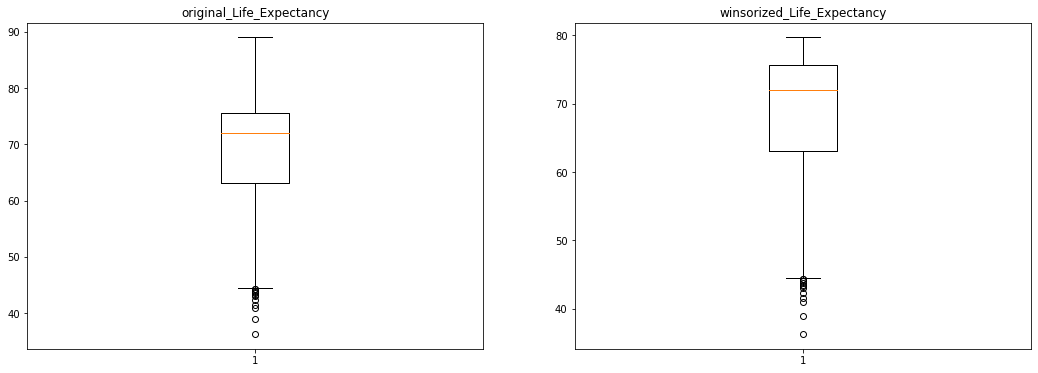

In [222]:
# Winsorize Life_Expectancy
from scipy.stats.mstats import winsorize
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Life_Expectancy = df0['Life_Expectancy']
plt.boxplot(original_Life_Expectancy)
plt.title("original_Life_Expectancy")

plt.subplot(1,2,2)
winsorized_Life_Expectancy = winsorize(df0['Life_Expectancy'],(0.0,0.1))
plt.boxplot(winsorized_Life_Expectancy)
plt.title("winsorized_Life_Expectancy")
plt.show()

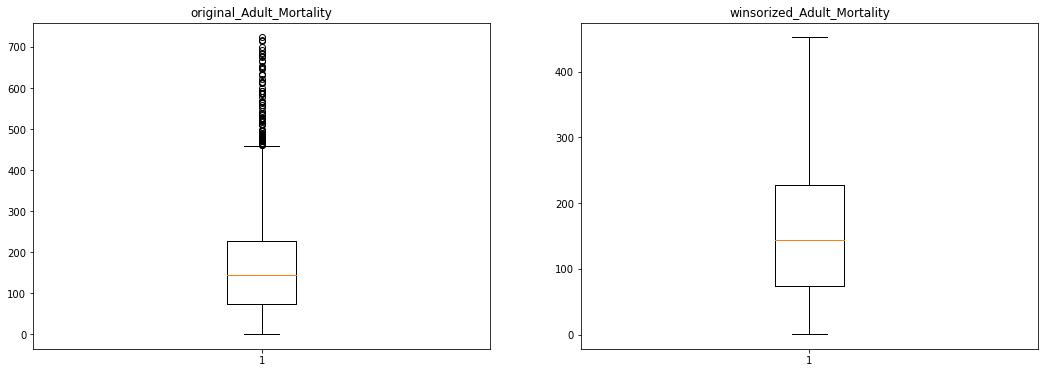

In [223]:
# Winsorize Adult_Mortality
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Adult_Mortality = df0['Adult_Mortality']
plt.boxplot(original_Adult_Mortality)
plt.title("original_Adult_Mortality")

plt.subplot(1,2,2)
winsorized_Adult_Mortality = winsorize(df0['Adult_Mortality'],(0,0.03))
plt.boxplot(winsorized_Adult_Mortality)
plt.title("winsorized_Adult_Mortality")

plt.show()

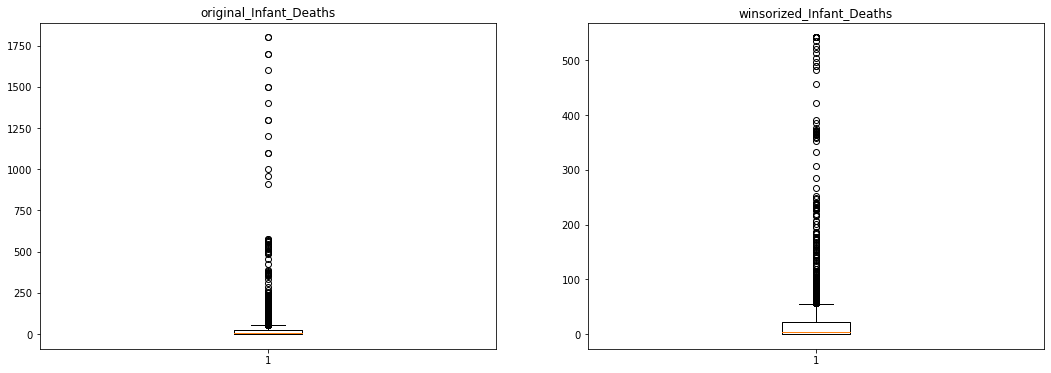

In [224]:
# Winsorize Infant_Deaths
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Infant_Deaths = df0['Infant_Deaths']
plt.boxplot(original_Infant_Deaths)
plt.title("original_Infant_Deaths")

plt.subplot(1,2,2)
winsorized_Infant_Deaths = winsorize(df0['Infant_Deaths'],(0,0.008))
plt.boxplot(winsorized_Infant_Deaths)
plt.title("winsorized_Infant_Deaths")

plt.show()

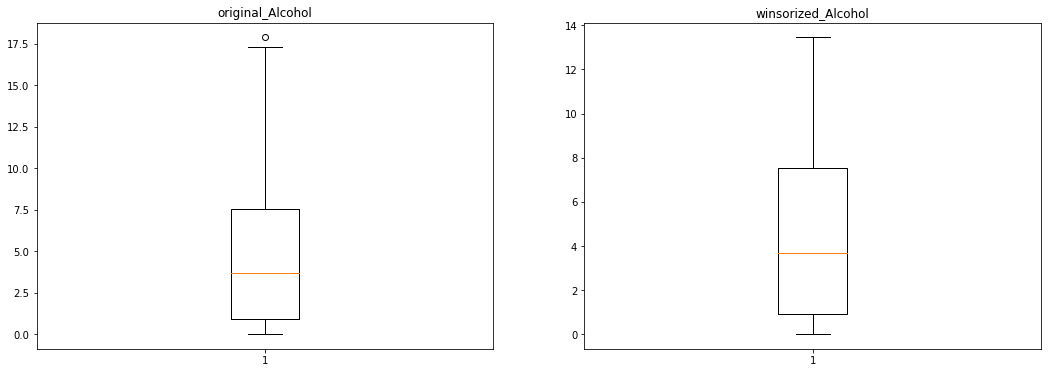

In [225]:
# Winsorize Alcohol
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Alcohol = df0['Alcohol']
plt.boxplot(original_Alcohol)
plt.title("original_Alcohol")

plt.subplot(1,2,2)
winsorized_Alcohol = winsorize(df0['Alcohol'],(0,0.01))
plt.boxplot(winsorized_Alcohol)
plt.title("winsorized_Alcohol")

plt.show()

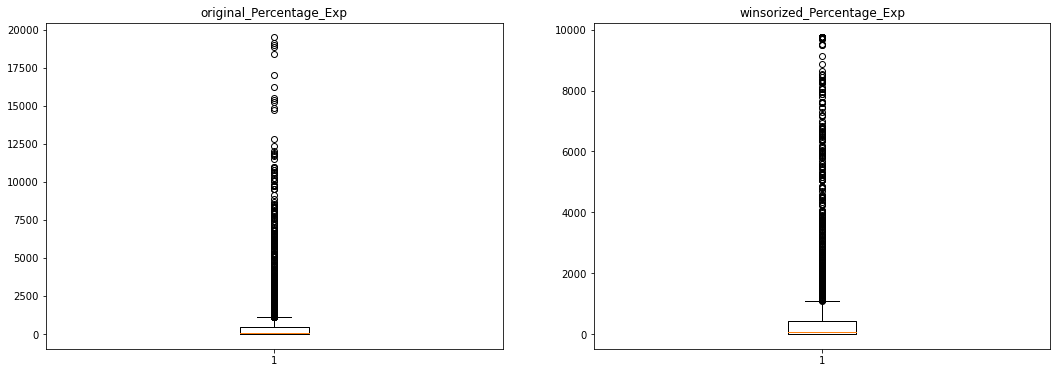

In [226]:
# Winsorize Percentage_Exp
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Percentage_Exp = df0['Percentage_Exp']
plt.boxplot(original_Percentage_Exp)
plt.title("original_Percentage_Exp")

plt.subplot(1,2,2)
winsorized_Percentage_Exp = winsorize(df0['Percentage_Exp'],(0,0.012))
plt.boxplot(winsorized_Percentage_Exp)
plt.title("winsorized_Percentage_Exp")

plt.show()

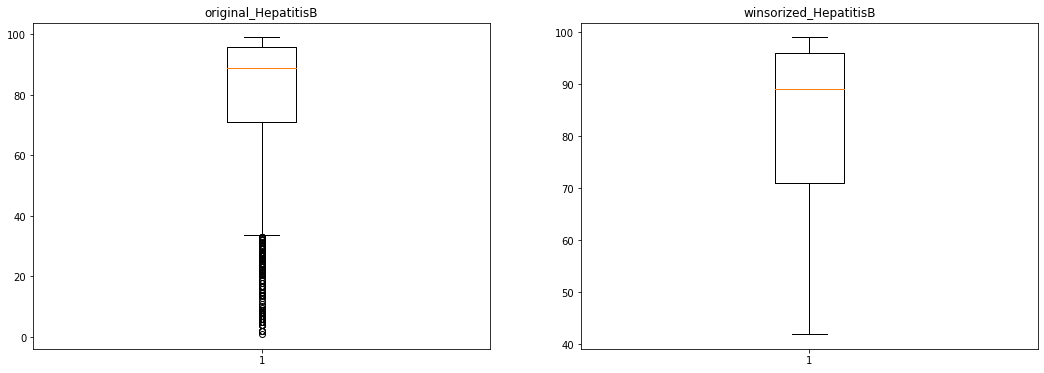

In [227]:
# Winsorize HepatitisB
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_HepatitisB = df0['HepatitisB']
plt.boxplot(original_HepatitisB)
plt.title("original_HepatitisB")

plt.subplot(1,2,2)
winsorized_HepatitisB = winsorize(df0['HepatitisB'],(0.11,0))
plt.boxplot(winsorized_HepatitisB)
plt.title("winsorized_HepatitisB")

plt.show()

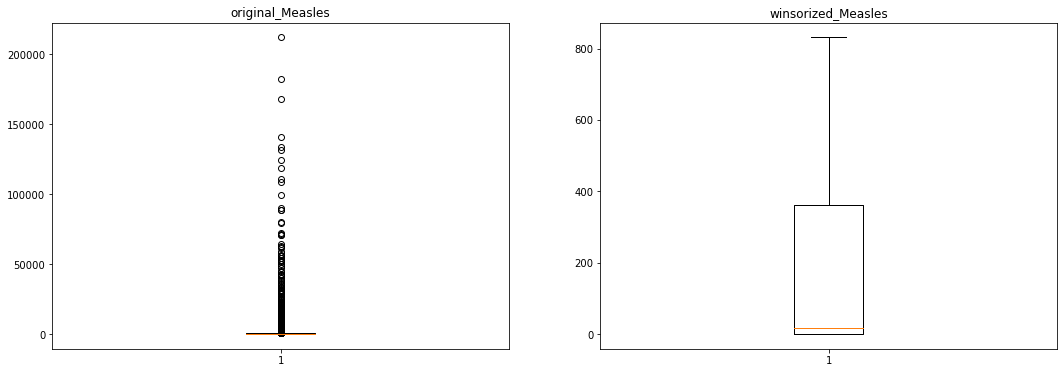

In [228]:
# Winsorize Measles
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Measles = df0['Measles']
plt.boxplot(original_Measles)
plt.title("original_Measles")

plt.subplot(1,2,2)
winsorized_Measles = winsorize(df0['Measles'],(0,0.19))
plt.boxplot(winsorized_Measles)
plt.title("winsorized_Measles")

plt.show()

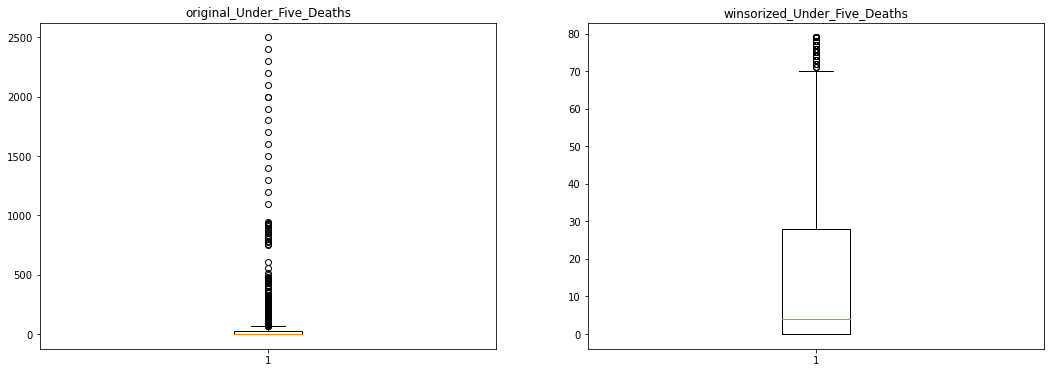

In [229]:
# Winsorize Under_Five_Deaths
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Under_Five_Deaths = df0['Under_Five_Deaths']
plt.boxplot(original_Under_Five_Deaths)
plt.title("original_Under_Five_Deaths")

plt.subplot(1,2,2)
winsorized_Under_Five_Deaths = winsorize(df0['Under_Five_Deaths'],(0,0.12))
plt.boxplot(winsorized_Under_Five_Deaths)
plt.title("winsorized_Under_Five_Deaths")

plt.show()

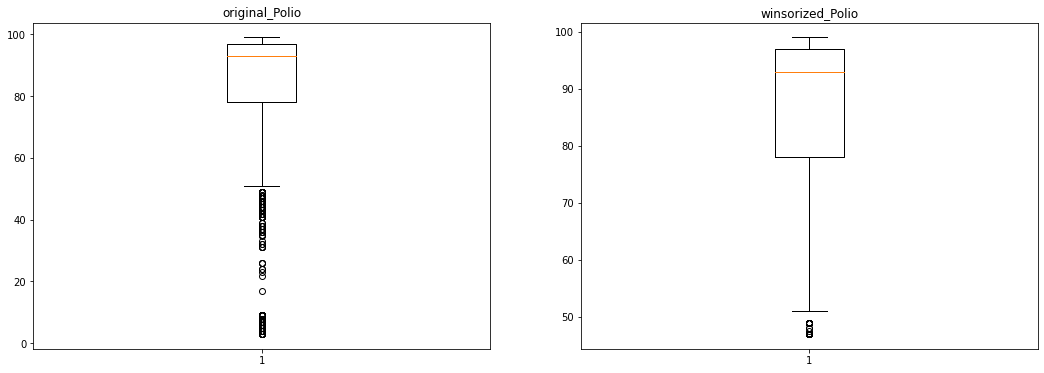

In [230]:
# Winsorize Polio
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Polio = df0['Polio']
plt.boxplot(original_Polio)
plt.title("original_Polio")

plt.subplot(1,2,2)
winsorized_Polio = winsorize(df0['Polio'],(0.09,0))
plt.boxplot(winsorized_Polio)
plt.title("winsorized_Polio")

plt.show()

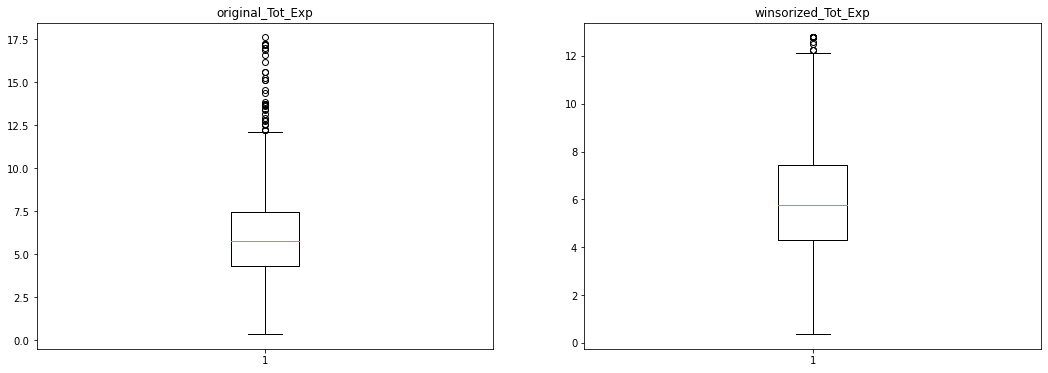

In [231]:
# Winsorize Tot_Exp
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Tot_Exp = df0['Tot_Exp']
plt.boxplot(original_Tot_Exp)
plt.title("original_Tot_Exp")

plt.subplot(1,2,2)
winsorized_Tot_Exp = winsorize(df0['Tot_Exp'],(0,0.01))
plt.boxplot(winsorized_Tot_Exp)
plt.title("winsorized_Tot_Exp")

plt.show()

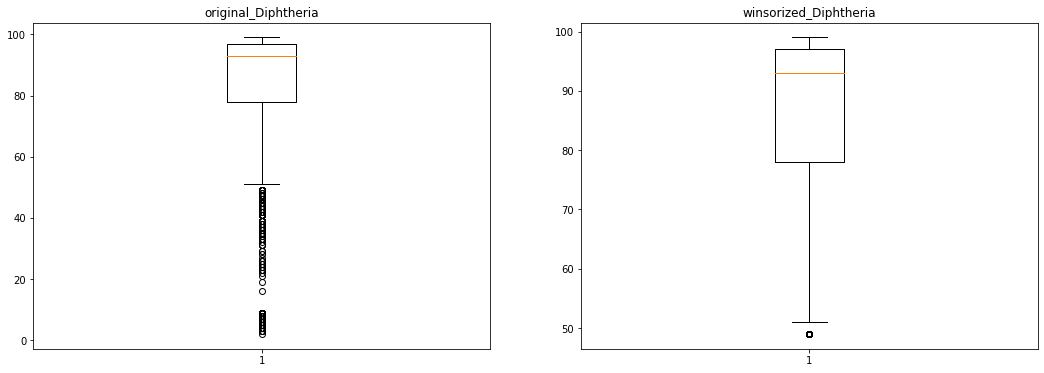

In [232]:
# Winsorize Diphtheria
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Diphtheria = df0['Diphtheria']
plt.boxplot(original_Diphtheria)
plt.title("original_Diphtheria")

plt.subplot(1,2,2)
winsorized_Diphtheria = winsorize(df0['Diphtheria'],(0.10,0))
plt.boxplot(winsorized_Diphtheria)
plt.title("winsorized_Diphtheria")

plt.show()

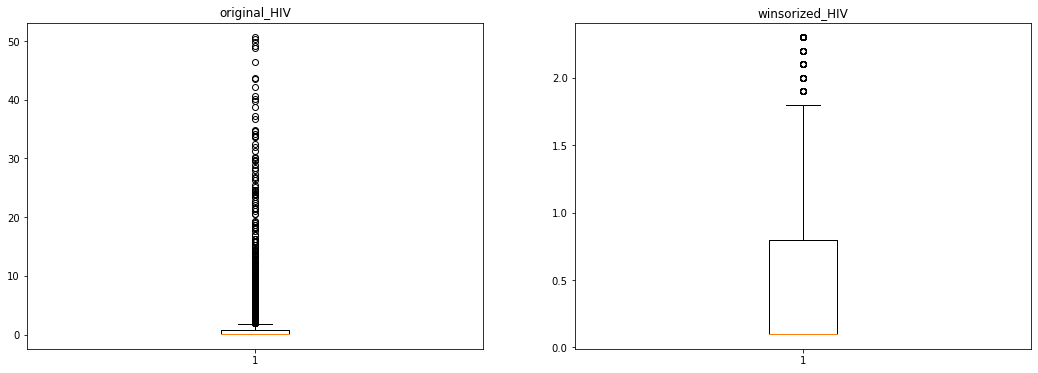

In [233]:
# Winsorize HIV/AIDS
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_HIV = df0['HIV/AIDS']
plt.boxplot(original_HIV)
plt.title("original_HIV")

plt.subplot(1,2,2)
winsorized_HIV = winsorize(df0['HIV/AIDS'],(0,0.16))
plt.boxplot(winsorized_HIV)
plt.title("winsorized_HIV")

plt.show()

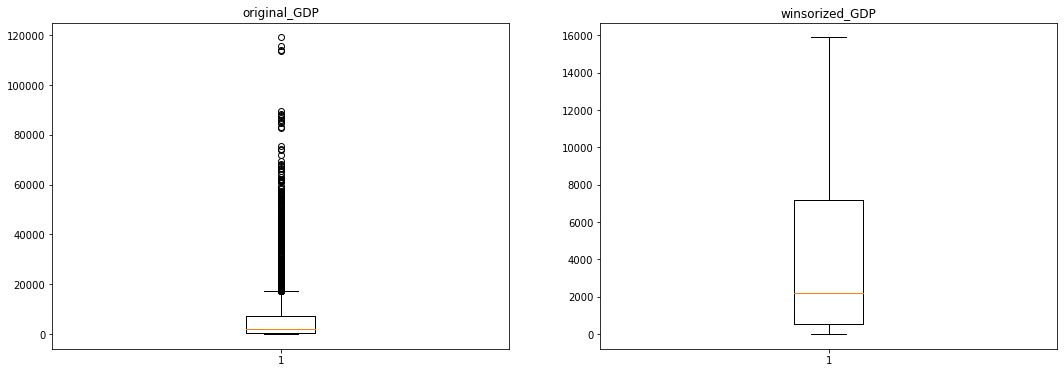

In [234]:
# Winsorize GDP
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_GDP = df0['GDP']
plt.boxplot(original_GDP)
plt.title("original_GDP")

plt.subplot(1,2,2)
winsorized_GDP = winsorize(df0['GDP'],(0,0.13))
plt.boxplot(winsorized_GDP)
plt.title("winsorized_GDP")

plt.show()

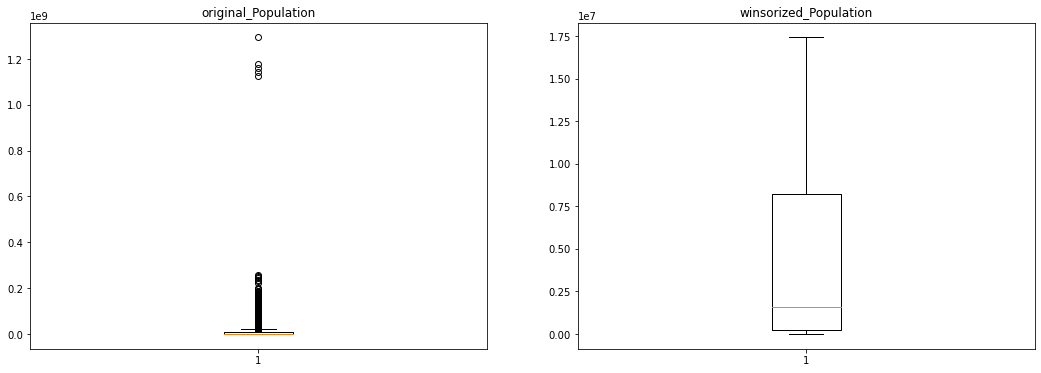

In [235]:
# Winsorize Population
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Population = df0['Population']
plt.boxplot(original_Population)
plt.title("original_Population")

plt.subplot(1,2,2)
winsorized_Population = winsorize(df0['Population'],(0,0.14))
plt.boxplot(winsorized_Population)
plt.title("winsorized_Population")

plt.show()

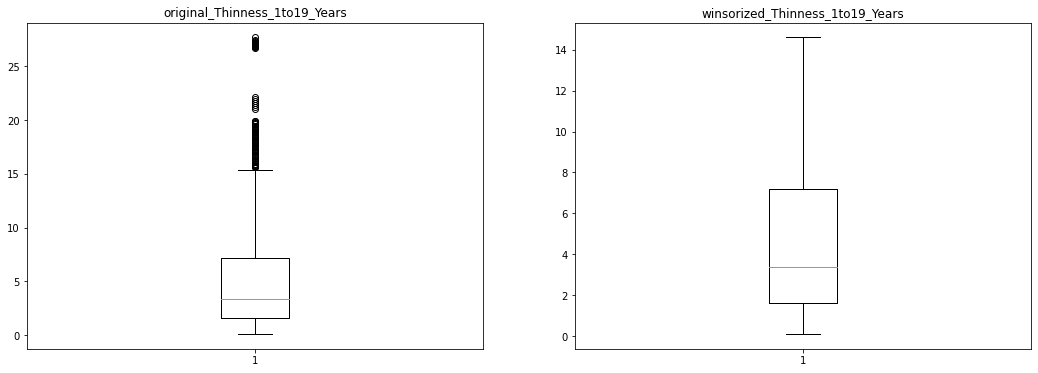

In [236]:
# Winsorize Thinness_1to19_Years
from scipy.stats.mstats import winsorize
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Thinness_1to19_Years = df0['Thinness_1to19_Years']
plt.boxplot(original_Thinness_1to19_Years)
plt.title("original_Thinness_1to19_Years")

plt.subplot(1,2,2)
winsorized_Thinness_1to19_Years = winsorize(df0['Thinness_1to19_Years'],(0,0.04))
plt.boxplot(winsorized_Thinness_1to19_Years)
plt.title("winsorized_Thinness_1to19_Years")

plt.show()

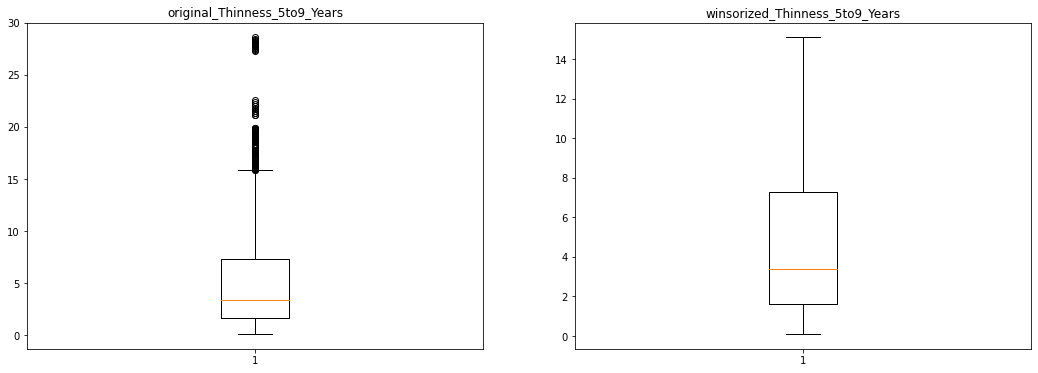

In [237]:
# Winsorize Thinness_5to9_Years
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Thinness_5to9_Years = df0['Thinness_5to9_Years']
plt.boxplot(original_Thinness_5to9_Years)
plt.title("original_Thinness_5to9_Years")

plt.subplot(1,2,2)
winsorized_Thinness_5to9_Years = winsorize(df0['Thinness_5to9_Years'],(0,0.04))
plt.boxplot(winsorized_Thinness_5to9_Years)
plt.title("winsorized_Thinness_5to9_Years")

plt.show()

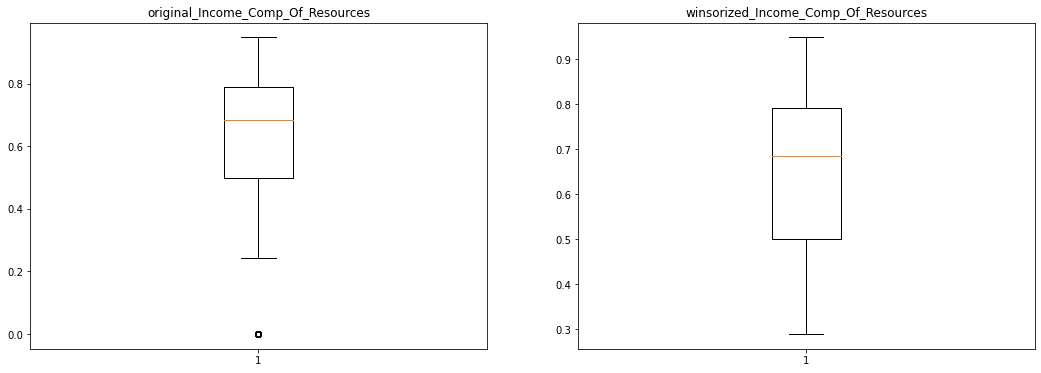

In [238]:
# Winsorize Income_Comp_Of_Resources
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Income_Comp_Of_Resources = df0['Income_Comp_of_Resources']
plt.boxplot(original_Income_Comp_Of_Resources)
plt.title("original_Income_Comp_Of_Resources")

plt.subplot(1,2,2)
winsorized_Income_Comp_Of_Resources = winsorize(df0['Income_Comp_of_Resources'],(0.05,0))
plt.boxplot(winsorized_Income_Comp_Of_Resources)
plt.title("winsorized_Income_Comp_Of_Resources")

plt.show()

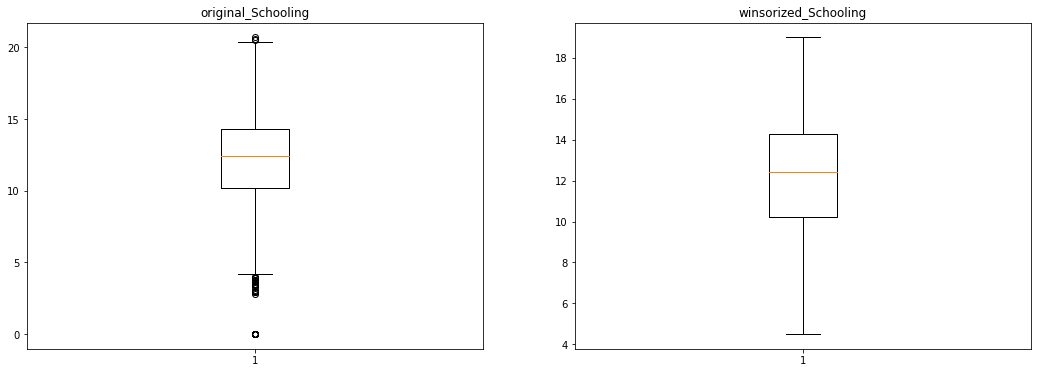

In [239]:
# Winsorize Schooling
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
original_Schooling = df0['Schooling']
plt.boxplot(original_Schooling)
plt.title("original_Schooling")

plt.subplot(1,2,2)
winsorized_Schooling = winsorize(df0['Schooling'],(0.02,0.01))
plt.boxplot(winsorized_Schooling)
plt.title("winsorized_Schooling")

plt.show()

In [240]:
# Check number of Outliers after Winsorization for each variable.
win_list = [winsorized_Life_Expectancy,winsorized_Adult_Mortality,winsorized_Infant_Deaths,winsorized_Alcohol,
            winsorized_Percentage_Exp,winsorized_HepatitisB,winsorized_Under_Five_Deaths,winsorized_Polio,winsorized_Tot_Exp,winsorized_Diphtheria\
            ,winsorized_HIV,winsorized_GDP,winsorized_Population\
            ,winsorized_Thinness_1to19_Years,winsorized_Thinness_5to9_Years,winsorized_Income_Comp_Of_Resources,winsorized_Schooling]

for variable in win_list:
    q75, q25 = np.percentile(variable, [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    
    print("Number of outliers after winsorization : {}".format(len(np.where((variable > max_val) | (variable < min_val))[0])))
    

Number of outliers after winsorization : 12
Number of outliers after winsorization : 0
Number of outliers after winsorization : 315
Number of outliers after winsorization : 0
Number of outliers after winsorization : 389
Number of outliers after winsorization : 0
Number of outliers after winsorization : 394
Number of outliers after winsorization : 282
Number of outliers after winsorization : 35
Number of outliers after winsorization : 301
Number of outliers after winsorization : 542
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0


In [241]:
# Adding winsorized variables to the data frame.
df0['winsorized_Life_Expectancy'] = winsorized_Life_Expectancy
df0['winsorized_Adult_Mortality'] = winsorized_Adult_Mortality
df0['winsorized_Infant_Deaths'] = winsorized_Infant_Deaths
df0['winsorized_Alcohol'] = winsorized_Alcohol
df0['winsorized_Percentage_Exp'] = winsorized_Percentage_Exp
df0['winsorized_HepatitisB'] = winsorized_HepatitisB
df0['winsorized_Under_Five_Deaths'] = winsorized_Under_Five_Deaths
df0['winsorized_Polio'] = winsorized_Polio
df0['winsorized_Tot_Exp'] = winsorized_Tot_Exp
df0['winsorized_Diphtheria'] = winsorized_Diphtheria
df0['winsorized_HIV'] = winsorized_HIV
df0['winsorized_GDP'] = winsorized_GDP
df0['winsorized_Population'] = winsorized_Population
df0['winsorized_Thinness_1to19_Years'] = winsorized_Thinness_1to19_Years
df0['winsorized_Thinness_5to9_Years'] = winsorized_Thinness_5to9_Years
df0['winsorized_Income_Comp_Of_Resources'] = winsorized_Income_Comp_Of_Resources
df0['winsorized_Schooling'] = winsorized_Schooling

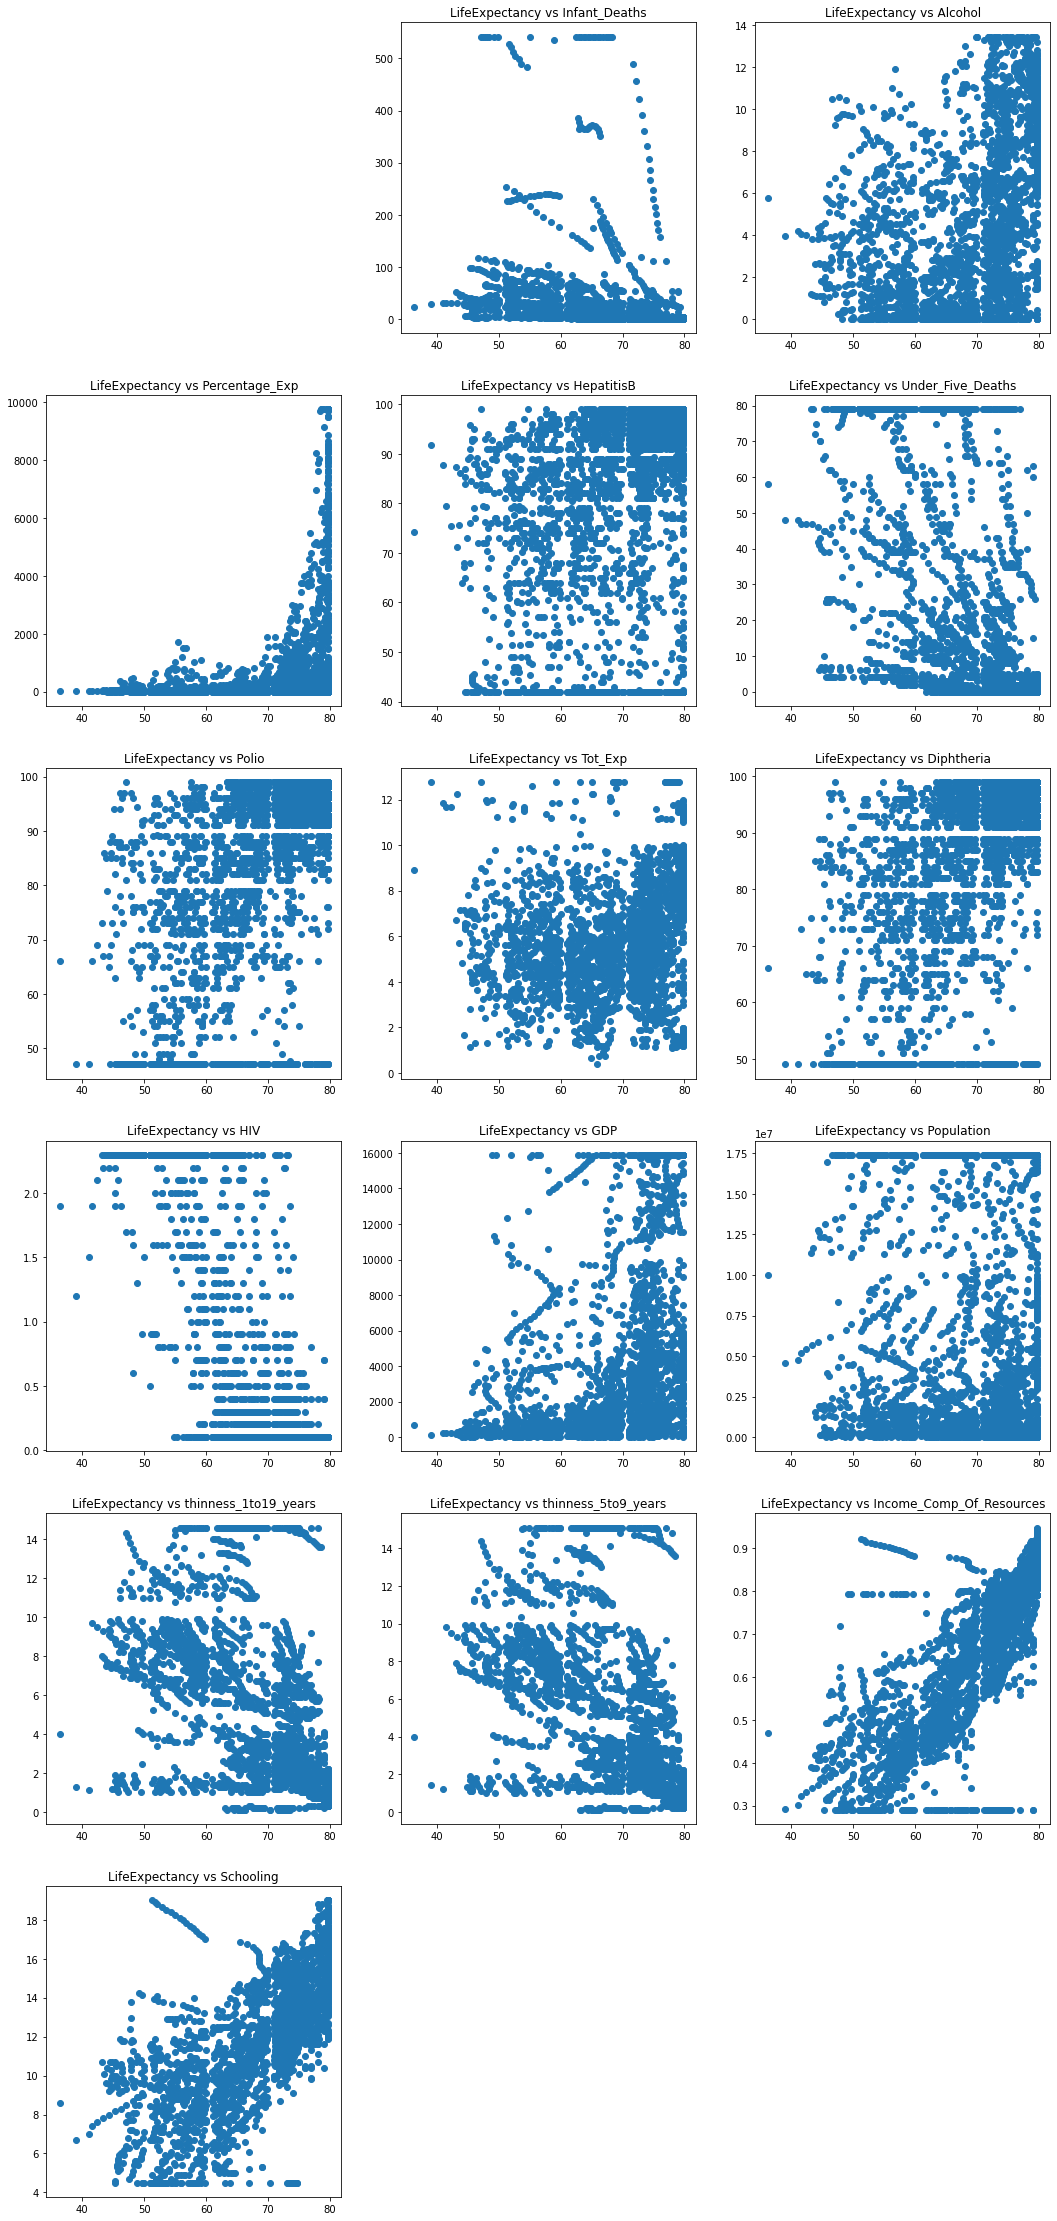

In [242]:
# Scatter plot between the target variable(winsorized_Life_Expectancy) and all continuous variables.
plt.figure(figsize=(18,40))

# plt.subplot(6,3,1)
# plt.scatter(df0["winsorized_Life_Expectancy"], df0["winsorized_Adult_Mortality"])
# plt.title("LifeExpectancy vs AdultMortality")

plt.subplot(6,3,2)
plt.scatter(df0["winsorized_Life_Expectancy"], df0["winsorized_Infant_Deaths"])
plt.title("LifeExpectancy vs Infant_Deaths")

plt.subplot(6,3,3)
plt.scatter(df0["winsorized_Life_Expectancy"], df0["winsorized_Alcohol"])
plt.title("LifeExpectancy vs Alcohol")

plt.subplot(6,3,4)
plt.scatter(df0["winsorized_Life_Expectancy"], df0["winsorized_Percentage_Exp"])
plt.title("LifeExpectancy vs Percentage_Exp")

plt.subplot(6,3,5)
plt.scatter(df0["winsorized_Life_Expectancy"], df0["winsorized_HepatitisB"])
plt.title("LifeExpectancy vs HepatitisB")

plt.subplot(6,3,6)
plt.scatter(df0["winsorized_Life_Expectancy"], df0["winsorized_Under_Five_Deaths"])
plt.title("LifeExpectancy vs Under_Five_Deaths")

plt.subplot(6,3,7)
plt.scatter(df0["winsorized_Life_Expectancy"], df0["winsorized_Polio"])
plt.title("LifeExpectancy vs Polio")

plt.subplot(6,3,8)
plt.scatter(df0["winsorized_Life_Expectancy"], df0["winsorized_Tot_Exp"])
plt.title("LifeExpectancy vs Tot_Exp")

plt.subplot(6,3,9)
plt.scatter(df0["winsorized_Life_Expectancy"], df0["winsorized_Diphtheria"])
plt.title("LifeExpectancy vs Diphtheria")

plt.subplot(6,3,10)
plt.scatter(df0["winsorized_Life_Expectancy"], df0["winsorized_HIV"])
plt.title("LifeExpectancy vs HIV")

plt.subplot(6,3,11)
plt.scatter(df0["winsorized_Life_Expectancy"], df0["winsorized_GDP"])
plt.title("LifeExpectancy vs GDP")

plt.subplot(6,3,12)
plt.scatter(df0["winsorized_Life_Expectancy"], df0["winsorized_Population"])
plt.title("LifeExpectancy vs Population")

plt.subplot(6,3,13)
plt.scatter(df0["winsorized_Life_Expectancy"], df0["winsorized_Thinness_1to19_Years"])
plt.title("LifeExpectancy vs thinness_1to19_years")

plt.subplot(6,3,14)
plt.scatter(df0["winsorized_Life_Expectancy"], df0["winsorized_Thinness_5to9_Years"])
plt.title("LifeExpectancy vs thinness_5to9_years")

plt.subplot(6,3,15)
plt.scatter(df0["winsorized_Life_Expectancy"], df0["winsorized_Income_Comp_Of_Resources"])
plt.title("LifeExpectancy vs Income_Comp_Of_Resources")

plt.subplot(6,3,16)
plt.scatter(df0["winsorized_Life_Expectancy"], df0["winsorized_Schooling"])
plt.title("LifeExpectancy vs Schooling")


plt.show()

In [243]:
# Correlation of winsorized variables
le_win = df0.iloc[:,21:]
le_win['Country'] = df0['Country']
le_win['Year'] = df0['Year']
le_win['Status'] = df0['Status']
le_win_num = le_win.iloc[:,:-3]
cormat = le_win_num.corr()

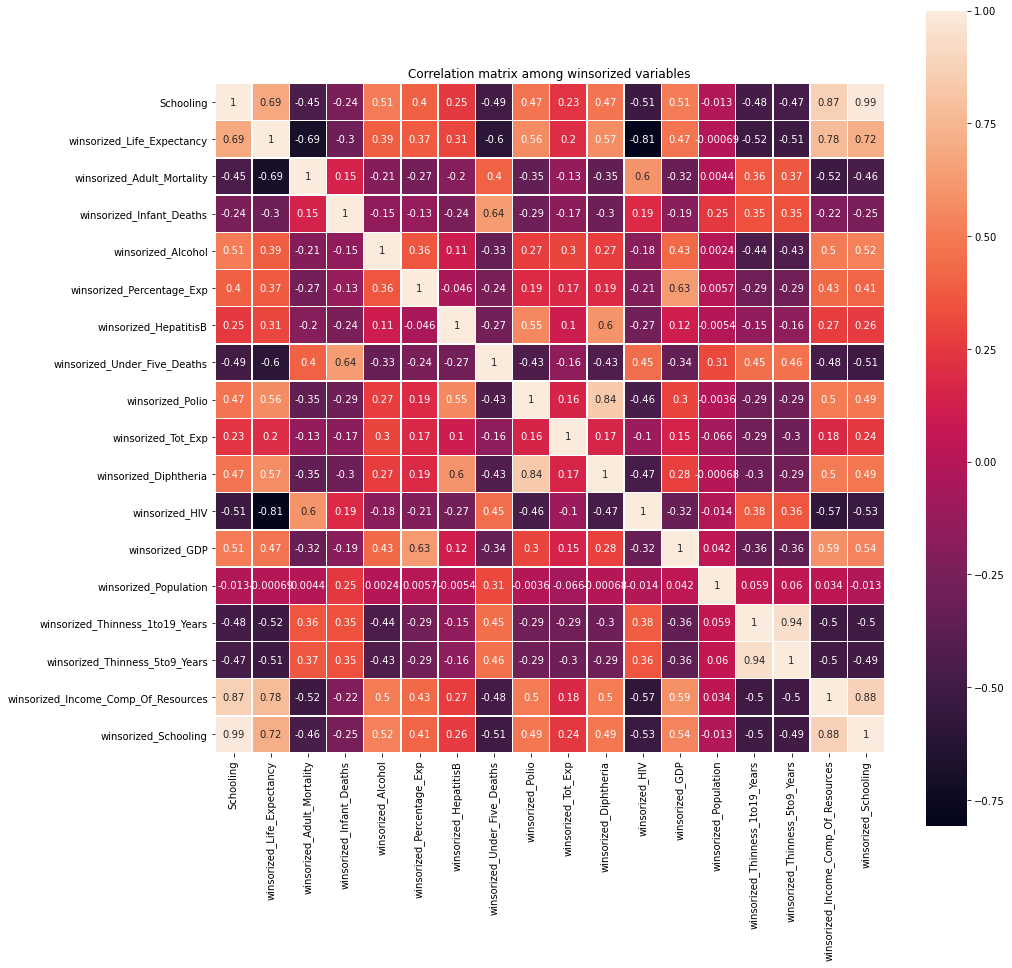

In [244]:
plt.figure(figsize=(15,15))
sns.heatmap(cormat, square=True, annot=True, linewidths=.5)
plt.title("Correlation matrix among winsorized variables")
plt.show()

## Observations

### winsorized_Income_Comp_Of_Resources is correlated with winsorized_Schooling.
### winsorized_thinness_1to19_years and winsorized_thinness_5to9_years are correlated.
### winsorized_Polio and winsorized_Diphtheria are correlated.
### winsorized_Percentage_Exp and winsorized_GDP are correlated.
### winsorized_Income_Comp_Of_Resources and winsorized_Life_Expectancy are correlated.
### winsorized_Life_Expectancy and winsorized_Schooling are correlated.
### winsorized_Infant_Deaths and winsorized_Under_Five_Deaths are correlated.
### winsorized_HIV has negative relation with winsorized_Life_Expectancy.
### winsorized_Adult_Mortality has negative relation with winsorized_Life_Expectancy.